# Neural network

* Example implementation of a neural network: multilayer perceptron
* Derive surface salinity from surface temperature, surface, longitude, latitude and time 
* Training data: ROMS model of the Ligurian Sea

Load all necessary modules. Some modules might need to be installed.

In [1]:
using Statistics
using NCDatasets
using Flux
using Flux: throttle
using PyPlot
using MLDataUtils

loaded


Download and inspect the input data file

In [5]:
fname = "ocean_avg_part.nc"
if !isfile(fname)
    download("https://dox.ulg.ac.be/index.php/s/rGvTilIGbbRRs0u/download",fname)
end

ds = Dataset(fname)


Dataset: ocean_avg_part.nc
Group: /

Dimensions
   tracer = 2
   s_rho = 32
   s_w = 33
   boundary = 4
   eta_rho = 150
   xi_rho = 276
   eta_psi = 149
   xi_psi = 275
   eta_u = 150
   xi_u = 275
   eta_v = 149
   xi_v = 276
   ocean_time = 4

Variables
  Akk_bak  
    Attributes:
     long_name            = background vertical mixing coefficient for turbulent energy
     units                = meter2 second-1

  Akp_bak  
    Attributes:
     long_name            = background vertical mixing coefficient for length scale
     units                = meter2 second-1

  Akt_bak   (2)
    Datatype:    Float64
    Dimensions:  tracer
    Attributes:
     long_name            = background vertical mixing coefficient for tracers
     units                = meter2 second-1

  Akv_bak  
    Attributes:
     long_name            = background vertical mixing coefficient for momentum
     units                = meter2 second-1

  Cs_r   (32)
    Datatype:    Float64
    Dimensions:  s_rho
    A

Load the data from the NetCDF file

In [6]:
n = 1:4
lon = nomissing(ds["lon_rho"][:],NaN)
lat = nomissing(ds["lat_rho"][:],NaN)
temp = nomissing(ds["temp"][:,:,end,n],NaN)
salt = nomissing(ds["salt"][:,:,end,n],NaN)
zeta = nomissing(ds["zeta"][:,:,n],NaN)

ocean_time = nomissing(ds["ocean_time"][n])
mask = nomissing(ds["mask_rho"][:,:]) .== 1;
close(ds)

In [7]:
doy = dayofyear.(ocean_time)

4-element Array{Int64,1}:
 32
 33
 34
 35

Replicate the data so that all arrays has the same number of dimensions

In [8]:
Ntimes = length(ocean_time);
lon3 = repeat(lon,inner=(1,1,Ntimes))
lat3 = repeat(lat,inner=(1,1,Ntimes));
time3 = repeat(reshape(1:Ntimes,(1,1,Ntimes)),inner=(size(lon,1),size(lon,2),1))
doy3 = repeat(reshape(doy,(1,1,Ntimes)),inner=(size(lon,1),size(lon,2),1))
mask3 = repeat(mask,inner=(1,1,Ntimes));

@show size(time3),size(lon3)

(size(time3), size(lon3)) = ((276, 150, 4), (276, 150, 4))


((276, 150, 4), (276, 150, 4))

Helper function for plotting

In [9]:
cmap = "jet"
function plotvar(var; cl = extrema(var[isfinite.(var)]))
    pcolor(lon,lat,var[:,:,end]; cmap=cmap); 
    clim(cl)
    colorbar(orientation="horizontal");
    contour(lon,lat,Int.(mask),[0.5],colors="k")
    gca()[:set_aspect](1/cos(pi * mean(lat)/180))
end



plotvar (generic function with 1 method)

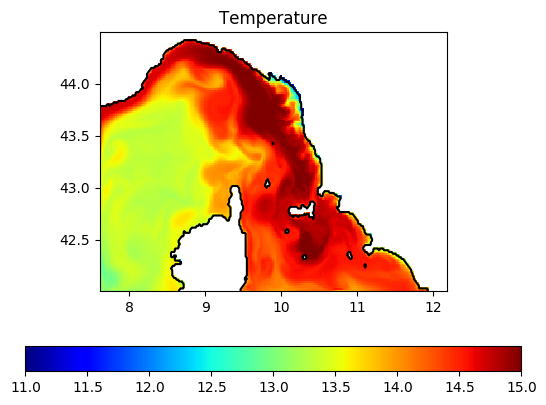

In [14]:
plotvar(temp[:,:,end],cl = [11,15]); title("Temperature");

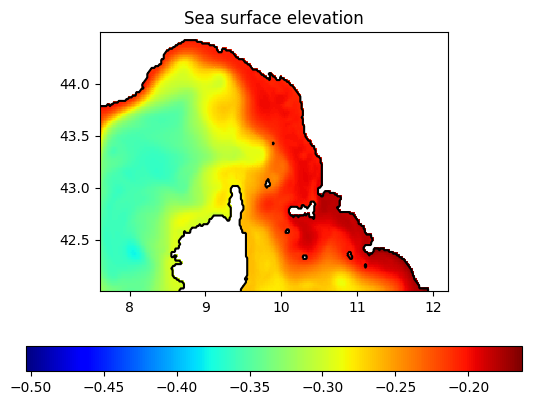

In [11]:
plotvar(zeta[:,:,end]); title("Sea surface elevation");

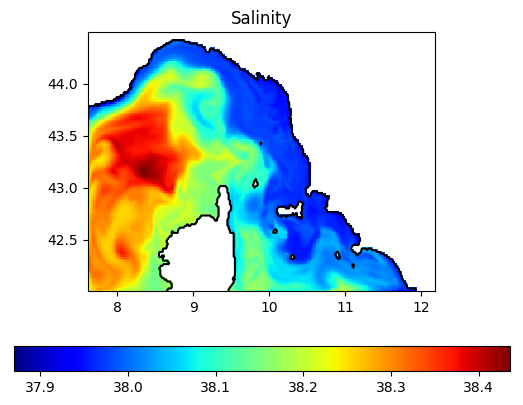

In [12]:
plotvar(salt[:,:,end]); title("Salinity");

Location of pseudo-observations

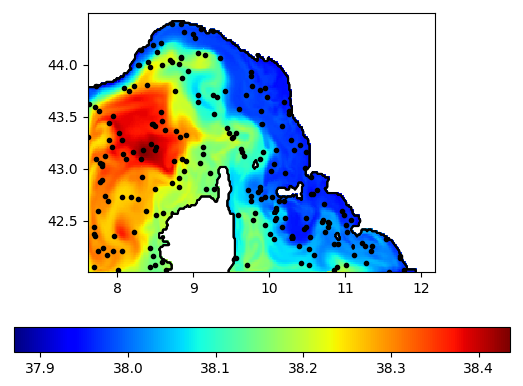

PyObject <matplotlib.contour.QuadContourSet object at 0x7f8bc272f3c8>

In [15]:
sel = (rand(Float64,size(temp)) .< 0.01) .& mask;
sel_last = sel .& (time3 .== maximum(time3))
plotvar(salt[:,:,end])
plot(lon3[sel_last],lat3[sel_last],"k.")
contour(lon,lat,Int.(mask),[0.5],colors="k")

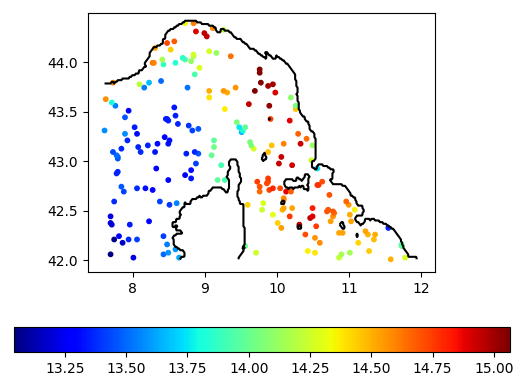

In [16]:
scatter(lon3[sel_last],lat3[sel_last],10,temp[sel_last]; cmap=cmap);
colorbar(orientation="horizontal");
contour(lon,lat,mask,[0.5],colors="k");
gca()[:set_aspect](1/cos(pi * mean(lat)/180))

In [18]:
X = vcat(lon3[sel]',lat3[sel]',cos.(2*pi*doy3[sel]/365)',sin.(2*pi*doy3[sel]/365)',temp[sel]',zeta[sel]')
Y = salt[sel]'

@show size(X)
@show size(Y)

meanX = mean(X,dims=2)
meanY = mean(Y,dims=2)

X = X .- meanX
Y = Y .- meanY


size(X) = (6, 824)
size(Y) = (1, 824)


1×824 Array{Float32,2}:
 -0.00808716  -0.0403786  0.126682  …  -0.141739  -0.131344  -0.131199

In [19]:
m = Chain(Dense(size(X,1),4,σ),
    Dense(4,4,σ),
    Dense(4,4,σ),
    Dense(4,3,σ),
    Dense(3,1),
)
loss(x, y) = Flux.mse(m(x), y)
evalcb = () -> @show(sqrt(loss(X, Y)))

#8 (generic function with 1 method)

In [14]:
#m = gpu(m)
#X = gpu(Float32.(X))
#Y = gpu(Float32.(Y))


In [15]:
size(X)

(6, 836)

In [20]:
dataset = batchview((X,Y),size=300);
η = 0.001 # learning rate

@time for i = 1:25000
   Flux.train!(loss, dataset, ADAM(Flux.params(m),η))
   if (i% 1000) == 0
      evalcb()
   end
end

┌ Warning: The specified values for size and/or count will result in 224 unused data points
└ @ MLDataPattern /home/abarth/.julia/packages/MLDataPattern/mX21p/src/dataview.jl:204


sqrt(loss(X, Y)) = 0.056409830449582574 (tracked)
sqrt(loss(X, Y)) = 0.05174555448421176 (tracked)
sqrt(loss(X, Y)) = 0.04367244364578477 (tracked)
sqrt(loss(X, Y)) = 0.03585415389036315 (tracked)
sqrt(loss(X, Y)) = 0.036146953949663205 (tracked)
sqrt(loss(X, Y)) = 0.03492687748972769 (tracked)
sqrt(loss(X, Y)) = 0.03415099895071906 (tracked)
sqrt(loss(X, Y)) = 0.0340614534002798 (tracked)
sqrt(loss(X, Y)) = 0.034149196505765915 (tracked)
sqrt(loss(X, Y)) = 0.03431120450047063 (tracked)
sqrt(loss(X, Y)) = 0.03451145604127705 (tracked)
sqrt(loss(X, Y)) = 0.034734900818728834 (tracked)
sqrt(loss(X, Y)) = 0.03497344222174213 (tracked)
sqrt(loss(X, Y)) = 0.035220961546342015 (tracked)
sqrt(loss(X, Y)) = 0.03547128574296052 (tracked)
sqrt(loss(X, Y)) = 0.035717353747899194 (tracked)
sqrt(loss(X, Y)) = 0.03595120556679906 (tracked)
sqrt(loss(X, Y)) = 0.03616482070462014 (tracked)
sqrt(loss(X, Y)) = 0.03635151779321265 (tracked)
sqrt(loss(X, Y)) = 0.03650681726516721 (tracked)
sqrt(loss(X, Y)

In [21]:
Ypred = Tracker.data(m(X))
@show extrema(Y)
@show extrema(Ypred)

extrema(Y) = (-0.22238159f0, 0.31478882f0)
extrema(Ypred) = (-0.2042784924761657, 0.22693669773444725)


(-0.2042784924761657, 0.22693669773444725)

In [23]:
Xall = vcat(lon3[:]',lat3[:]',cos.(2*pi*doy3[:]/365)',sin.(2*pi*doy3[:]/365)',temp[:]',zeta[:]') .- meanX;
Yall = Tracker.data(m(Xall)) .+ meanY
salt_pred = reshape(Yall,size(temp));

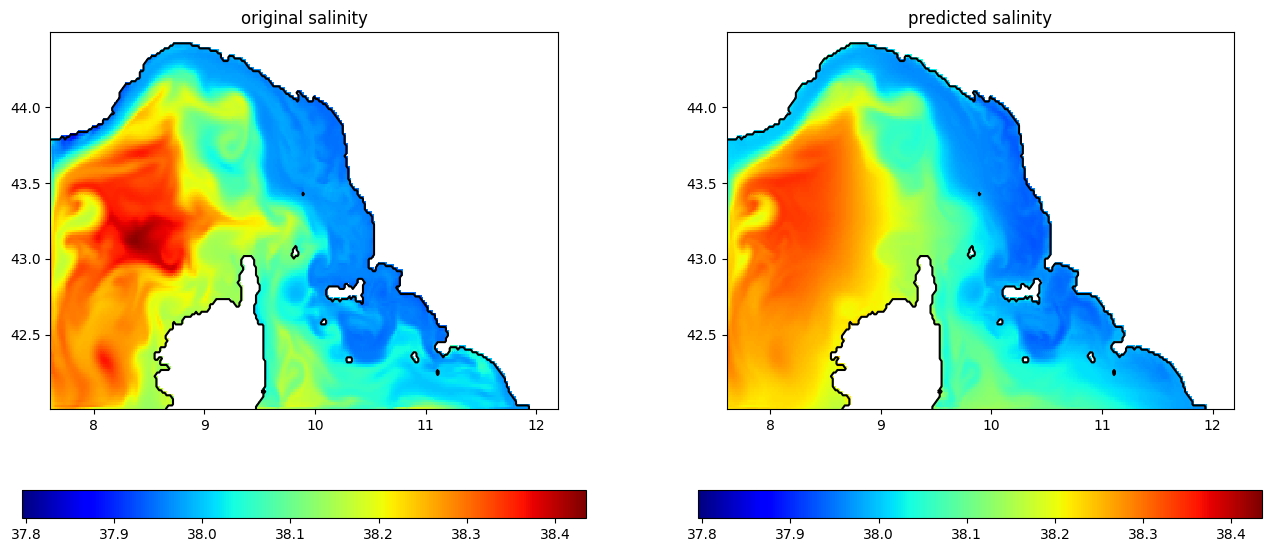

In [24]:
n = 3
cl = extrema(salt[isfinite.(salt)])
figure(figsize=(16,7))
subplot(1,2,1)
plotvar(salt[:,:,n],cl = cl)
title("original salinity");

subplot(1,2,2)
plotvar(salt_pred[:,:,n],cl = cl)
title("predicted salinity");


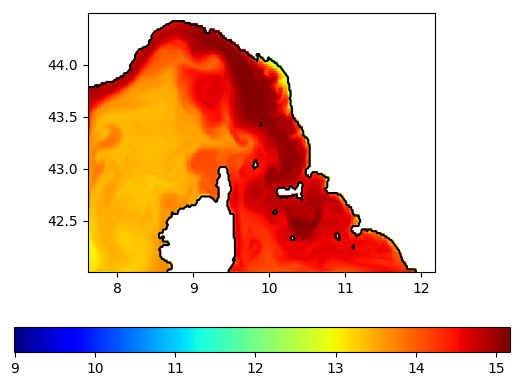

In [20]:
plotvar(temp[:,:,n])


# Final remarks

* Complex neural networks can take a long-time to converge
* A fast GPU can be beneficial
* Minimization can fail due to local minima
* Mini-batch approach (i.e. computing the gradient on a subset of the data) helps to converge to a global minimum.  